In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from IPython.display import clear_output

from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import cluster

### Performing unsupervised learning on Forbes' Billionaires profiles
### To see if billionaires can be clustered in differnet categories

# 1. Importing Data

In [2]:
df=pd.read_csv('data/2020_data_clean.csv')
df.head()

,Unnamed: 0,name,lastName,uri,worthChange,age,source_x,industry,gender,country,...,source_y,Source of Wealth,Residence,Citizenship,Marital Status,Children,Education,Self-Made Score,Philanthropy Score,self_made
0,0,A. Jayson Adair,Adair,a-jayson-adair,-12.191,52.0,damaged cars,Automotive,M,United States,...,"['damaged cars', ' Self Made']","damaged cars, Self Made","Dallas, Texas",United States,Married,2.0,NaN,NaN,NaN,True
1,1,Abhay Soi,Soi,abhay-soi,31.453,48.0,healthcare,Healthcare,M,India,...,"['healthcare', ' Self Made']","healthcare, Self Made","Mumbai, India",India,Married,2.0,"Master of Business Administration, European Un...",NaN,NaN,True
2,2,Adam Foroughi,Foroughi,adam-foroughi,-147.507,41.0,mobile games,Media & Entertainment,M,United States,...,"['mobile games', ' Self Made']","mobile games, Self Made","Truckee, California",United States,Married,NaN,NaN,NaN,NaN,True
3,3,Adam Neumann,Neumann,adam-neumann,-19.834,42.0,WeWork,Real Estate,M,Israel,...,"['WeWork', ' Self Made']","WeWork, Self Made","New York, New York",Israel,Married,5.0,City University of New York Baruch,NaN,NaN,True
4,4,Alan Miller & family,Miller,alan-miller-1,-5.252,84.0,healthcare services,Healthcare,M,United States,...,"['healthcare services', ' Self Made']","healthcare services, Self Made","Lower Merion, Pennsylvania",United States,Married,3.0,"Bachelor of Arts/Economics, College of William...",NaN,NaN,True


# 2. Data Processing

Numerical values

In [3]:
nums= [ 'worthChange', 'age','realTimeWorth' ] # data excluded : 'Children' 
df.Children=df.Children.fillna(value=0)

x=df[nums].copy(deep=True)

#normalizing the values
x=x.values
normalizer = preprocessing.MinMaxScaler()

x_scaled= normalizer.fit_transform(x)
x=pd.DataFrame(x_scaled, columns=nums)

Boolean Values

In [4]:
df['married']=df['Marital Status'].str.lower().str.contains("married")
bool=[ 'gender','married',  'self_made'] #
for col in bool: 
    x=x.merge(pd.get_dummies(df[col], prefix=col, drop_first=True),how="left", left_index=True, right_index=True)

Categorical Values

In [5]:
cat=[ 'industry',  'country'] #data excluded :residence(country)

for col in cat: 
    x=x.merge(pd.get_dummies(df[col], prefix=col),how="left", left_index=True, right_index=True)


# 3. Data Clustering 

## 3.1 Initializing model

In [6]:
from sklearn import cluster
kmeans= cluster.KMeans(n_clusters=8, random_state=10).fit(x.dropna())

unique, counts=np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

#calculate euclidian distance between centroids vs the other centroids in set for each features/dimensions 
centroids=kmeans.cluster_centers_
distance=[]


for i in range(centroids.shape[0]):
    distance.append(np.sum(centroids[i]-centroids, axis=0))
    
distance= np.array(distance)


## 3.2 Optimizing the model
(optimizing the number of clusters)

### 3.2a Clustering Metrics

credit for the code goes to : https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html

Computing adjusted_rand_score for 10 values of n_clusters
done in 1.483s
Computing v_measure_score for 10 values of n_clusters
done in 1.233s
Computing ami_score for 10 values of n_clusters
done in 1.110s
Computing mutual_info_score for 10 values of n_clusters
done in 1.066s


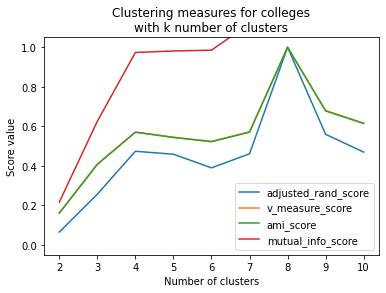

In [7]:


import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import metrics
import sklearn

def uniform_labelings_scores(score_func, n_clusters_range, y, dfex,
                             n_runs=1):
    """Compute score for 2 random uniform cluster labelings.

    Both random labelings have the same number of clusters for each value
    possible value in ``n_clusters_range``.

    When fixed_n_classes is not None the first labeling is considered a ground
    truth class assignment with fixed number of classes.
    """

    scores = np.zeros((len(n_clusters_range), n_runs))



    for i, k in enumerate(n_clusters_range):
        for j in range(n_runs):
            labels_a = y
            labels_b = sklearn.cluster.KMeans(n_clusters=k, random_state=10).fit(dfex).labels_
            scores[i, j] = score_func(labels_a, labels_b)
    return scores



def ami_score(U, V):
    return metrics.adjusted_mutual_info_score(U, V)

score_funcs = [
    metrics.adjusted_rand_score,
    metrics.v_measure_score,
    ami_score,
    metrics.mutual_info_score,
]


n_clusters_range = np.linspace(2, 10, 10).astype(int)

plt.figure(1)

plots = []
names = []
for score_func in score_funcs:
    print("Computing %s for %d values of n_clusters"
          % (score_func.__name__, len(n_clusters_range)))

    t0 = time()
    scores = uniform_labelings_scores(score_func, n_clusters_range, kmeans.labels_, x.dropna())
    print("done in %0.3fs" % (time() - t0))
    plots.append(plt.errorbar(
        n_clusters_range, np.median(scores, axis=1), scores.std(axis=1))[0])
    names.append(score_func.__name__)

plt.title("Clustering measures for colleges\n"
          "with k number of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Score value')
plt.legend(plots, names)
plt.ylim(bottom=-0.05, top=1.05)


plt.ylim(bottom=-0.05, top=1.05)
plt.legend(plots, names)
plt.show()

### 3.2b Silhouette Analysis

credit for the code goes to: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.11572517369477883
For n_clusters = 3 The average silhouette_score is : 0.13324517787992404
For n_clusters = 4 The average silhouette_score is : 0.13987929766191898
For n_clusters = 5 The average silhouette_score is : 0.11414285716384845
For n_clusters = 6 The average silhouette_score is : 0.12620692193091185
For n_clusters = 7 The average silhouette_score is : 0.1465924321299846
For n_clusters = 8 The average silhouette_score is : 0.1412192248242536


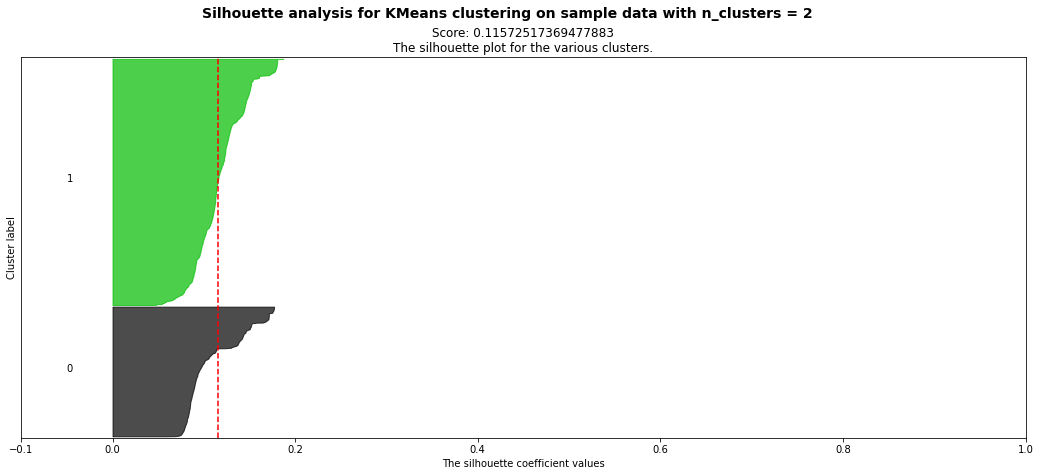

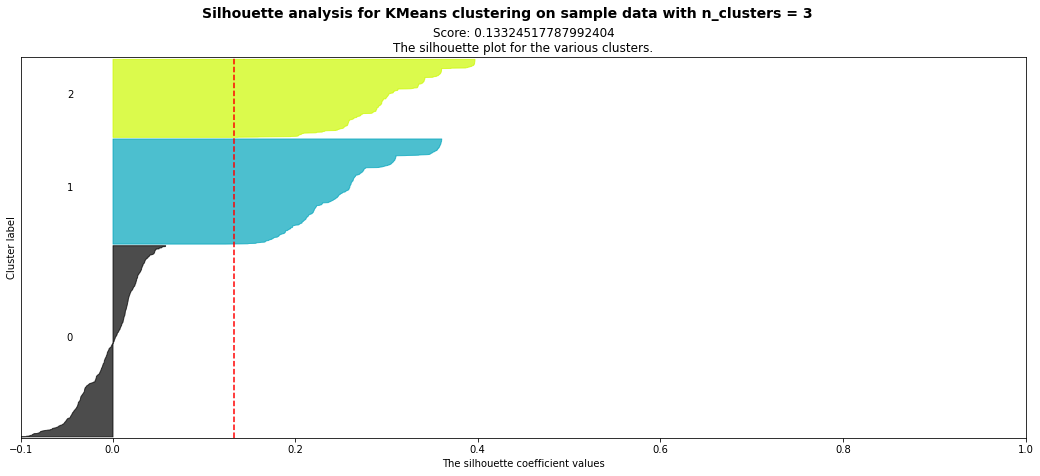

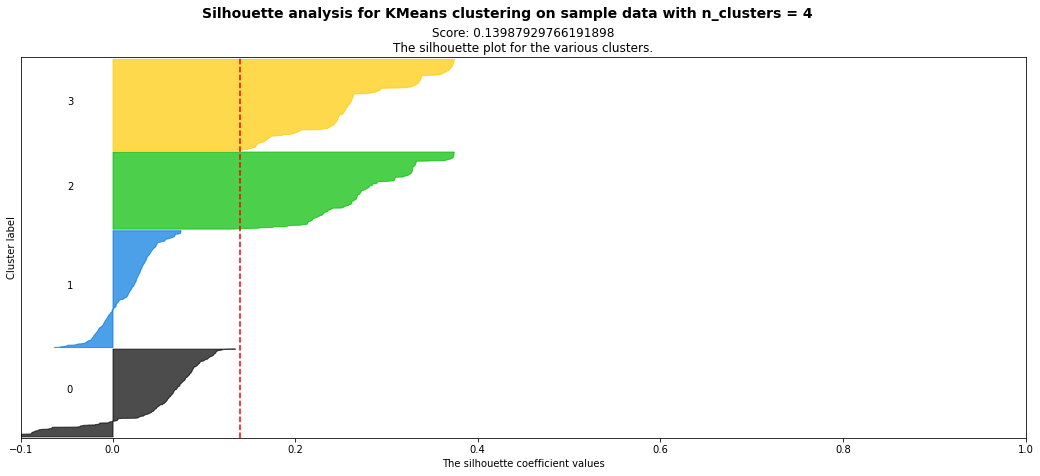

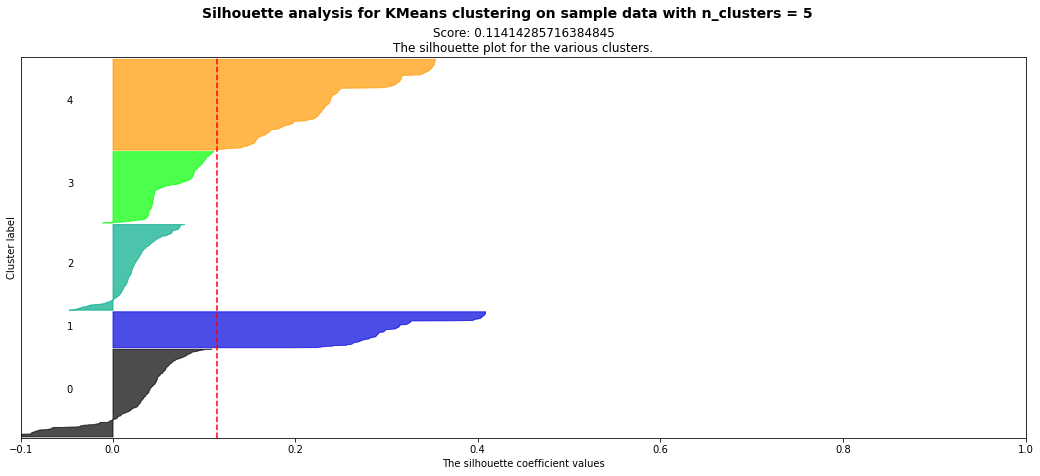

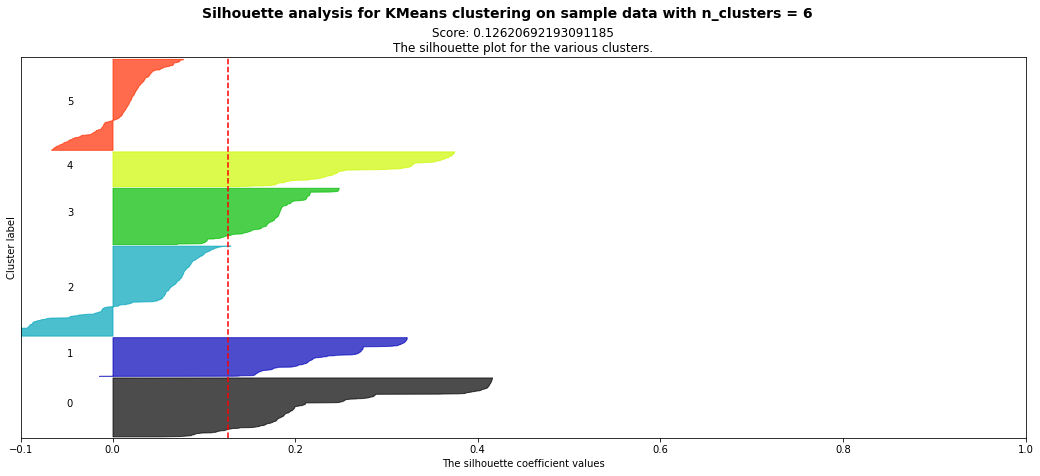

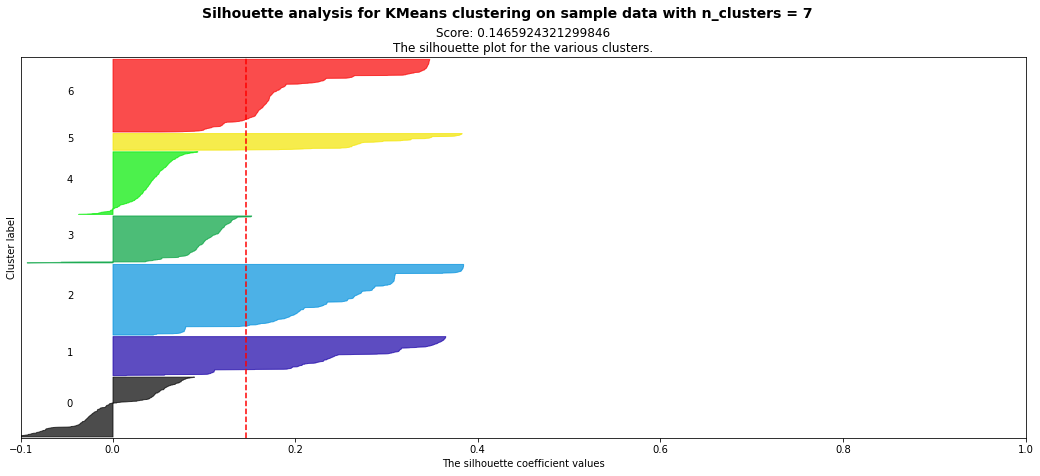

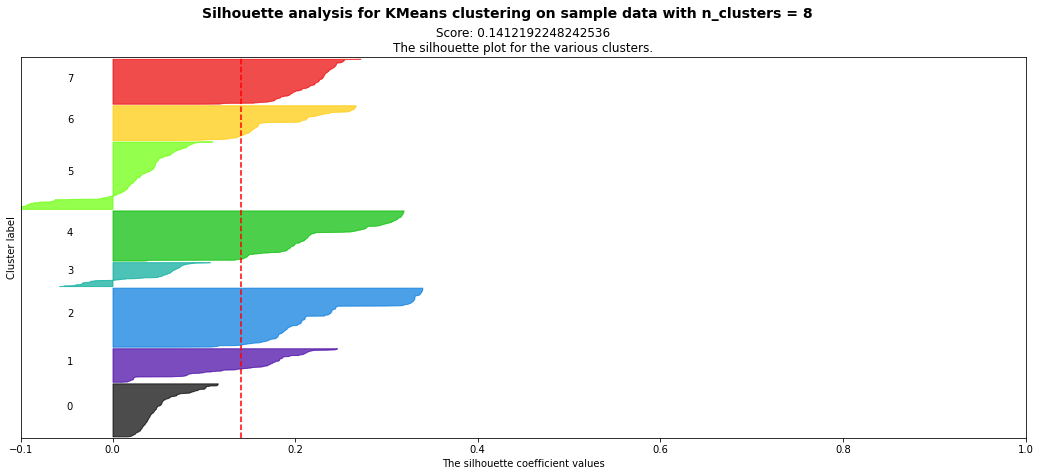

In [8]:
def cluster_silhouette(dfx, target, n_cluster, random_state, min_cluster=2):

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np

    X= dfx
    y=target

    range_n_clusters = np.arange(min_cluster, n_cluster+1)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        # fig, (ax1, ax2) = plt.subplots(1, 2)
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state= random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title(f'Score: {silhouette_avg}\nThe silhouette plot for the various clusters.')
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()

labels=kmeans.labels_
cluster_silhouette(x.dropna(), labels, n_cluster=8, random_state=10)

## 3.3 Running the Model

Based on the silhoute plots and the metrics calculated above. <br>
It looks like cluster of size 5 and of size 8 seems to give the best clustering

In [93]:
N_CLUSTERS = 8

kmeans= cluster.KMeans(n_clusters=N_CLUSTERS, random_state=10).fit(x.dropna())


In [99]:
def get_clusters_distance(centroids):
    """calculate euclidian distance between centroids vs the other centroids in set for each features/dimensions """
    distance=[]
    for i in range(centroids.shape[0]):
        distance.append(np.sum(centroids[i]-centroids, axis=0))
        
    return np.array(distance)

centroids_coordinates=kmeans.cluster_centers_
clusters_distances = get_clusters_distance(centroids_coordinates)

To understand the characteristics of a cluster we can get the relevant features of each clusters 

In [100]:
def get_relevant_features_distance(dist_matrix, features_name, n_features=10):
    """"
    Returns the top features for each clusters 
    defined as the dimensions where the clusters is fartest appart from the other clusters in euclidian distance
    """

    matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = matrix_abs.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        top_features_in_centroid = dist_matrix[i][sorted_centroid_features_idx[i]][:n_features]
        
        relevant_feat.append(dict(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    top_features_in_centroid
                )
            ))

    return relevant_feat


def get_relevant_features_centroids(dist_matrix, centroids, features_name):
    """"
        get relevant features but return the clusters centroids positions for those features
        instead of their relative distance to other clusters
    """

    matrix_abs =np.abs(dist_matrix)
    sorted_centroid_features_idx = matrix_abs.argsort(axis=1)[:,::-1]
    # sorted_centroid_features_values = np.take_along_axis(dist_matrix, sorted_centroid_features_idx, axis=1)

    relevant_feat=[]
    for i in range(dist_matrix.shape[0]):
        relevant_features_value = centroids[i][sorted_centroid_features_idx[i]][:10]
        
        relevant_feat.append(dict(
                zip(
                    [features_name[feature] for feature in sorted_centroid_features_idx[i]], 
                    relevant_features_value
                )
            ))

    return relevant_feat

Plotting the defining features of each clusters

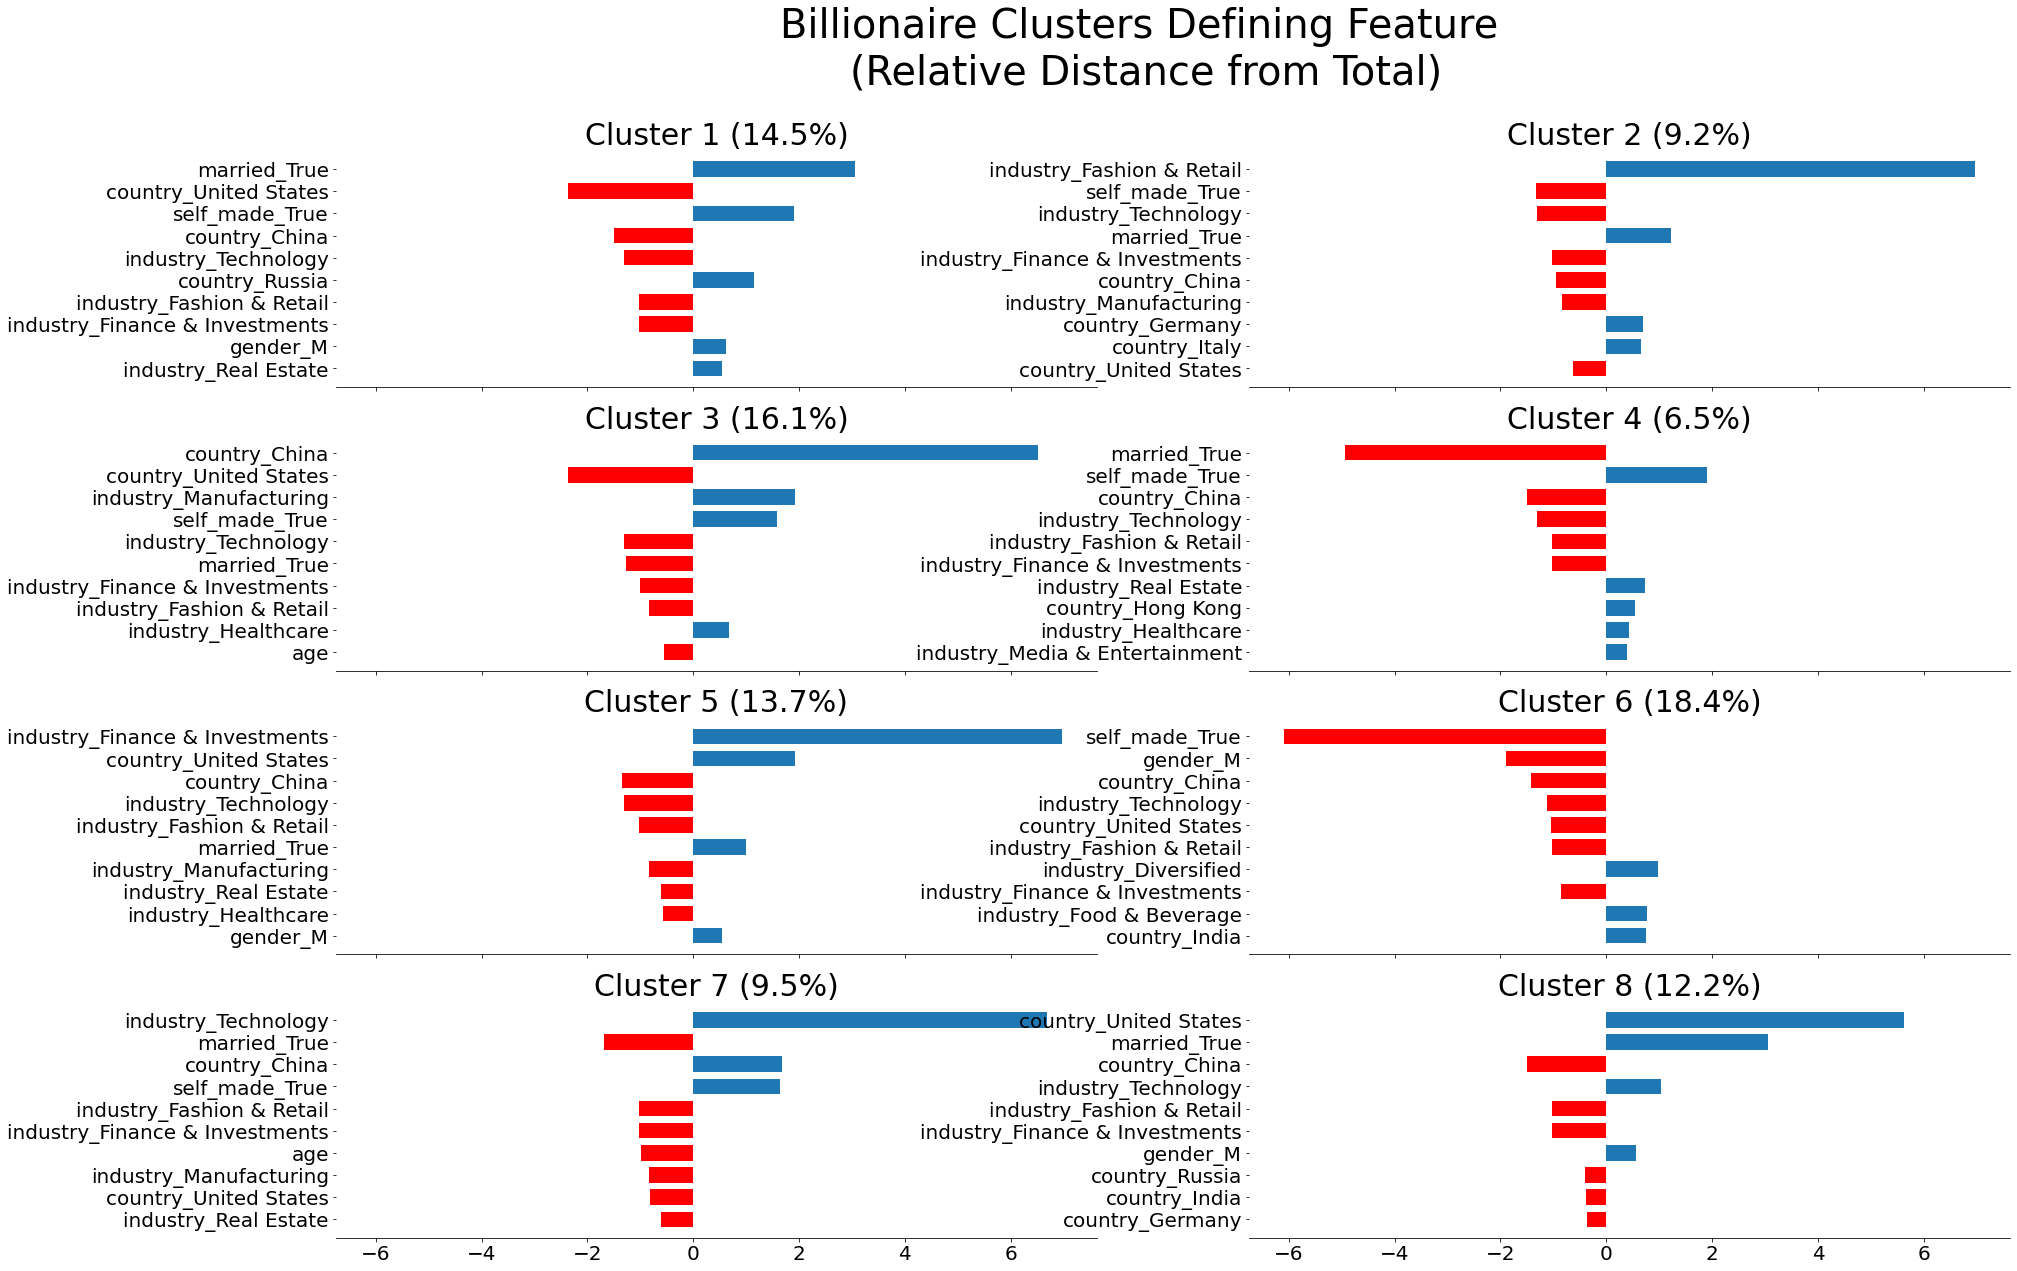

In [103]:
def get_clusters_size(kmeans):
    """ Function returning the size of each clusters as percent share of total"""
    _, counts=np.unique(kmeans.labels_, return_counts=True)
    counts= np.round_((counts/sum(counts))*100, decimals=1) #turn it into %
    return counts

def bar_color(values,color1,color2):
    return np.where(np.array(values)>0,color1,color2).T

def plot_feautures(features, title=None):
    if title is None:
        title="Billionaire Clusters Defining Features"

    cluster_size= get_clusters_size(kmeans)

    #making the plot
    fig, axes = plt.subplots(4, 2, figsize=(30, 20), sharex=True)
    axes = axes.flatten()

    #making a plot for each centroids
    for cluster_idx, cluster in enumerate(features):
        top_features = list(cluster.keys())
        weights=list(cluster.values())
        ax = axes[cluster_idx]
        ax.barh(top_features, weights, height=0.7, color= bar_color(weights, '#1f77b4', 'r'))
        ax.set_title(f'Cluster {cluster_idx +1} ({cluster_size[cluster_idx]}%)',
                        fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    return None

clusters_relative_distance=get_relevant_features_distance(clusters_distances, x.columns, n_features=10)
plot_feautures(clusters_relative_distance, title ='Billionaire Clusters Defining Feature \n(Relative Distance from Total)' )

# clusters_centroids=get_relevant_features_centroids(distance,kmeans.cluster_centers_, x.columns)
# plot_feautures(clusters_centroids)
    

It is useful to see who are the most representative members of a cluster <br>
(these are the points closest to the center of a cluster)

In [105]:
#Select which cluster to vizualize the top members
CLUSTER=4


dfx=df.iloc[x.dropna().index].copy(deep=True)
dfx["kmeans"]=kmeans.labels_
dfx["k_dist"]=kmeans.fit_transform(x.dropna()).min(axis=1) #get distance of each point from their cluster 

# print(get_relevant_features_centroids(distance,kmeans.cluster_centers_, x.columns)[cluster_n])
dfx.loc[dfx.kmeans==CLUSTER+1].sort_values(by=["k_dist"], axis=0, ascending=True).head(5)


,Unnamed: 0,name,lastName,uri,worthChange,age,source_x,industry,gender,country,...,Citizenship,Marital Status,Children,Education,Self-Made Score,Philanthropy Score,self_made,married,kmeans,k_dist
418,418,Neil Kadisha,Kadisha,neil-kadisha,-3.330,66.0,Qualcomm,NaN,M,United States,...,NaN,NaN,0.0,NaN,NaN,NaN,False,NaN,5,1.129018
266,266,"Jeffrey, S. Raikes",Raikes,jeffrey-s-raikes,-10.087,62.0,MSFT,NaN,M,United States,...,NaN,NaN,0.0,NaN,NaN,NaN,False,NaN,5,1.129651
334,334,Leonid Radvinsky,Radvinsky,leonid-radvinsky,0.000,39.0,NaN,NaN,M,United States,...,United States,Divorced,0.0,NaN,NaN,NaN,False,False,5,1.171481
2167,2167,Harsh Goenka,Goenka,harsh-goenka,-19.830,64.0,diversified,Diversified,M,India,...,India,Married,2.0,"Bachelor of Arts/Science, Calcutta University;...",NaN,NaN,False,True,5,1.357851
460,460,Rajan Raheja & family,Raheja,rajan-raheja,32.640,67.0,diversified,Diversified,M,India,...,India,Married,2.0,"Bachelor of Arts/Science, University of Mumbai",NaN,NaN,False,True,5,1.357921


Mapping the cluster on a 2D map using sklearn TSNE to vizualize high dimensional-data

The results are OK, but could be better

<AxesSubplot:xlabel='x', ylabel='y'>

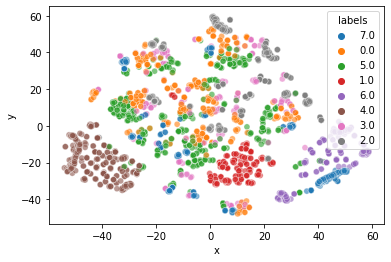

In [67]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                 init='random').fit_transform(x.dropna())
X_embedded.shape


X=np.c_[X_embedded, kmeans.labels_]
df1=pd.DataFrame(data=X, columns=["x", 'y', 'labels'])

df1.labels=df1.labels.astype(str)

sns.scatterplot(x="x", y="y", data=df1, hue="labels", alpha=0.6)